# Classification of Radar Returns from Iomosphere: Tabular Foundation Models vs. Tree-Based Methods

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("HFTOKEN")

Shape: (351, 35)
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

Dtypes:
 0       int64
1       int64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
30    float64
31    float64
32    float64
33    float64
34     object
dtype: object

Missing values per column:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
dtype: int64

Head:


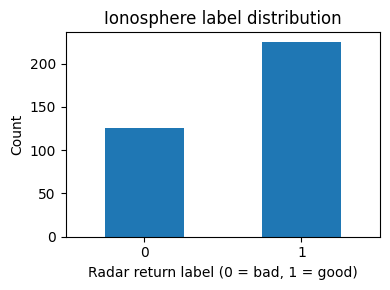

['g' 'b']
(351, 33) (351,)


In [2]:
import os
import inspect
import time
import torch, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

from tabpfn import TabPFNClassifier
from tabicl import TabICLClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

path = "./data/ionosphere.data"
df = pd.read_csv(path, sep=",", header=None)

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 60)

print("\nHead:\n", df.head())
print("\nSummary stats:\n", df.describe(include="all").T)

target_col = df.columns[-1]  # last column
X = df.drop(columns=[target_col])
y = df[target_col].map({"b": 0, "g": 1}).astype(int)
dataset_label = "ionosphere"

# Remove constant (zero-variance) features
const_cols = X.columns[X.nunique(dropna=True) <= 1]
print("Dropping constant columns:", list(const_cols))

X = X.drop(columns=const_cols)

print("New feature shape:", X.shape)

y_counts = y.value_counts().sort_index()
print(f"\nTarget column index: {target_col}")
print("\nLabel counts (0=bad, 1=good):\n", y_counts)

plt.figure(figsize=(4, 3))
y_counts.plot(kind="bar", rot=0)
plt.xlabel("Radar return label (0 = bad, 1 = good)")
plt.ylabel("Count")
plt.title("Ionosphere label distribution")
plt.tight_layout()
plt.show()

print(df.iloc[:5, -1].unique())
print(X.shape, y.shape)

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

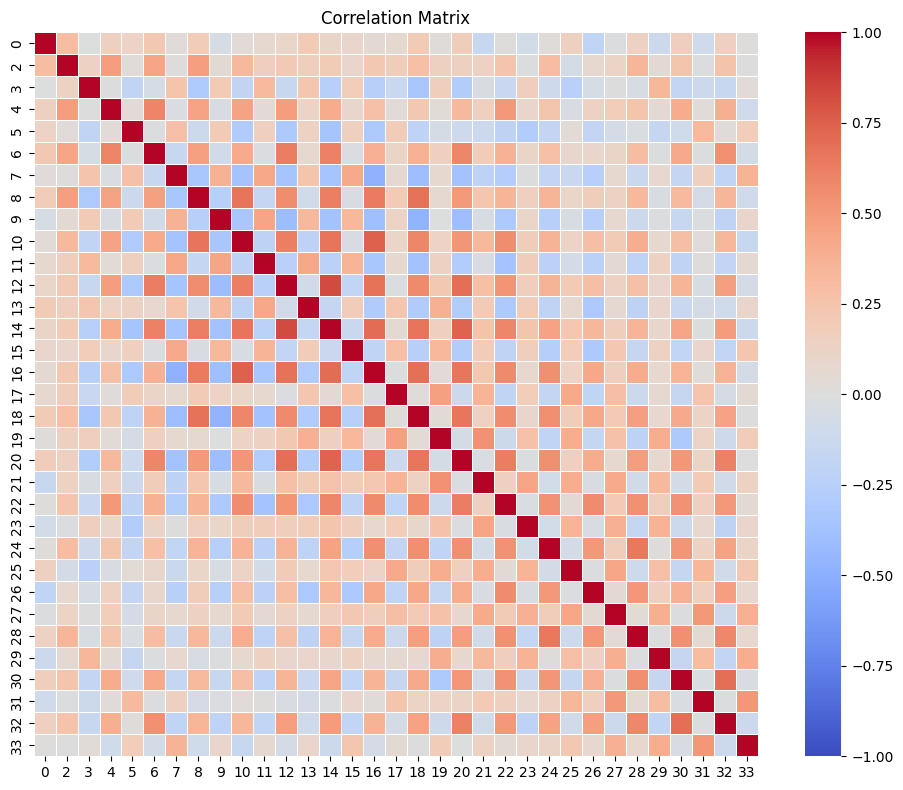

In [3]:
corr = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Plot Function

In [4]:
def plot_model_results(model_name):
    res = MODEL_RESULTS[model_name]
    cv_metrics_df = res["cv_metrics_df"]
    y_true_cv = res["y_true_cv"]
    y_pred_cv = res["y_pred_cv"]
    y_proba_cv = res["y_proba_cv"]
    dataset = res.get("dataset", "unknown dataset")

    # CV metrics box/strip
    metrics_long = cv_metrics_df.melt(
        id_vars=["fold"],
        value_vars=["acc", "auc"],
        var_name="metric",
        value_name="value",
    )
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=metrics_long, x="metric", y="value")
    sns.stripplot(data=metrics_long, x="metric", y="value", jitter=True, size=5)
    plt.title(f"{model_name} ({dataset}): CV metrics across folds")
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_true_cv, y_pred_cv, labels=[0, 1])
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} ({dataset}): Confusion matrix (pooled)")
    plt.tight_layout()
    plt.show()

    # ROC
    if len(np.unique(y_true_cv)) == 2:
        fpr, tpr, _ = roc_curve(y_true_cv, y_proba_cv)
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title(f"{model_name} ({dataset}): ROC curve (pooled)")
        plt.tight_layout()
        plt.show()

    # Precision–Recall
    prec, rec, _ = precision_recall_curve(y_true_cv, y_proba_cv)
    ap = average_precision_score(y_true_cv, y_proba_cv)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} ({dataset}): Precision–Recall curve (AP={ap:.3f})")
    plt.tight_layout()
    plt.show()

    # Reliability curve (simple binned calibration)
    bins = np.linspace(0.0, 1.0, 11)
    bin_ids = np.digitize(y_proba_cv, bins) - 1

    bin_centers, frac_pos = [], []
    for b in range(len(bins) - 1):
        m = bin_ids == b
        if m.sum() == 0:
            continue
        bin_centers.append((bins[b] + bins[b + 1]) / 2)
        frac_pos.append(y_true_cv[m].mean())

    plt.figure(figsize=(5, 4))
    plt.plot(bin_centers, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Predicted probability (bin center)")
    plt.ylabel("Empirical P(y=1)")
    plt.title(f"{model_name} ({dataset}): Reliability curve (pooled)")
    plt.tight_layout()
    plt.show()


### TabPFN (Classifier)

In [5]:
COOLDOWN_S = 0 # To reduce thermal throttling when benchmarking timing

MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"

y_bin = y.astype(int)

p = float(y_bin.mean())
print("Positive rate (default=1):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

# Use stratified CV
skf = cv

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"
print("CUDA available:", use_cuda, "| device:", device)
if use_cuda:
    print("GPU:", torch.cuda.get_device_name(0))

warm_n = min(256, len(X))
warm_model = TabPFNClassifier(device=device)
_ = warm_model.fit(X.iloc[:warm_n], y_bin.iloc[:warm_n])
_ = get_pos_proba(warm_model, X.iloc[:warm_n])
if use_cuda:
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabPFNClassifier(device=device)

    if use_cuda:
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if use_cuda:
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if use_cuda:
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if use_cuda:
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    bal_acc = balanced_accuracy_score(y_te, y_hat)
    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "bal_acc": bal_acc, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(
        f"{model_name} Fold {fold}: "
        f"BAL_ACC={bal_acc:.4f} ACC={acc:.4f} AUC={auc:.4f} | "
        f"fit={fit_s:.3f}s pred={pred_s:.3f}s"
    )

    del model
    gc.collect()
    if use_cuda:
        torch.cuda.empty_cache()

    # optional cool-down to reduce thermal throttling and get better benchmarks for timing
    if use_cuda and COOLDOWN_S > 0:
        time.sleep(COOLDOWN_S)

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
    "dataset": dataset_label,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"BAL_ACC={cv_metrics_df['bal_acc'].mean():.4f}±{cv_metrics_df['bal_acc'].std():.4f}, "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)

Positive rate (default=1): 0.6410256410256411
Majority baseline accuracy: 0.6410256410256411
CUDA available: True | device: cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
tabpfn Fold 1: BAL_ACC=0.9697 ACC=0.9718 AUC=0.9983 | fit=0.219s pred=0.639s
tabpfn Fold 2: BAL_ACC=0.9378 ACC=0.9429 AUC=0.9689 | fit=0.204s pred=0.635s
tabpfn Fold 3: BAL_ACC=0.9178 ACC=0.9286 AUC=0.9867 | fit=0.195s pred=0.698s
tabpfn Fold 4: BAL_ACC=0.9600 ACC=0.9714 AUC=0.9911 | fit=0.205s pred=0.633s
tabpfn Fold 5: BAL_ACC=0.9489 ACC=0.9571 AUC=0.9867 | fit=0.199s pred=0.736s

tabpfn 5-fold CV: BAL_ACC=0.9468±0.0202, ACC=0.9544±0.0187, AUC=0.9863±0.0108
Timing: fit=0.20s±0.01, predict=0.67s±0.05


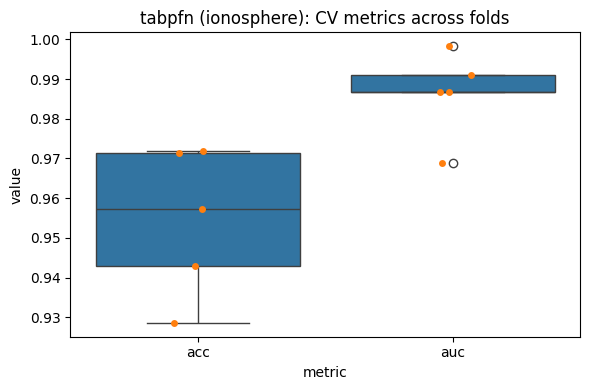

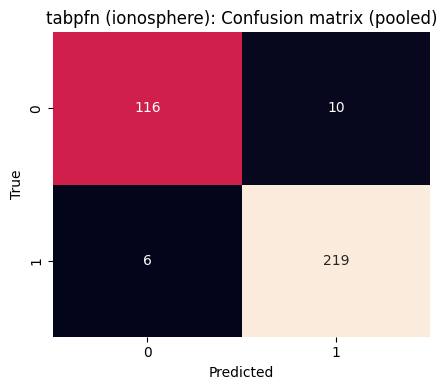

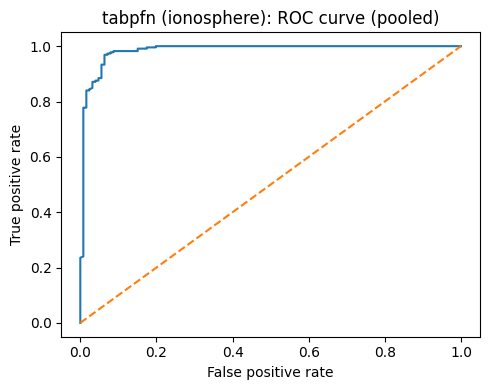

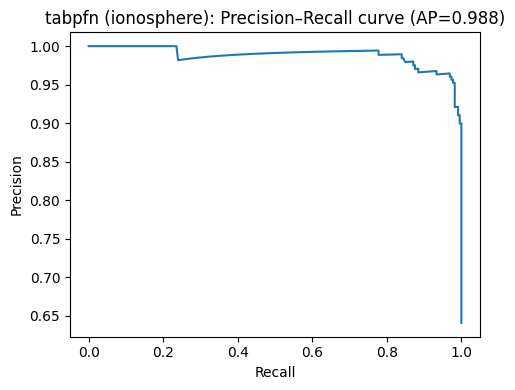

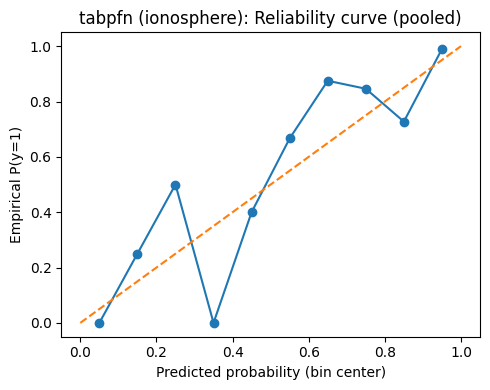

In [6]:
plot_model_results("tabpfn")

### TabICL

In [7]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabicl"

y_bin = y.astype(int)

p = float(y_bin.mean())
print("Positive rate (default=1):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

# Use stratified CV
skf = cv

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"
print("CUDA available:", use_cuda, "| device:", device)
if use_cuda:
    print("GPU:", torch.cuda.get_device_name(0))

warm_n = min(256, len(X))
warm_model = TabICLClassifier(device=device)
_ = warm_model.fit(X.iloc[:warm_n], y_bin.iloc[:warm_n])
_ = get_pos_proba(warm_model, X.iloc[:warm_n])
if use_cuda:
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabICLClassifier(device=device)

    if use_cuda:
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if use_cuda:
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if use_cuda:
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if use_cuda:
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    bal_acc = balanced_accuracy_score(y_te, y_hat)
    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "bal_acc": bal_acc, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(
        f"{model_name} Fold {fold}: "
        f"BAL_ACC={bal_acc:.4f} ACC={acc:.4f} AUC={auc:.4f} | "
        f"fit={fit_s:.3f}s pred={pred_s:.3f}s"
    )

    del model
    gc.collect()
    if use_cuda:
        torch.cuda.empty_cache()

    # optional cool-down to reduce thermal throttling and get better benchmarks for timing
    if use_cuda and COOLDOWN_S > 0:
        time.sleep(COOLDOWN_S)

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
    "dataset": dataset_label,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"BAL_ACC={cv_metrics_df['bal_acc'].mean():.4f}±{cv_metrics_df['bal_acc'].std():.4f}, "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)

Positive rate (default=1): 0.6410256410256411
Majority baseline accuracy: 0.6410256410256411
CUDA available: True | device: cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
tabicl Fold 1: BAL_ACC=0.9038 ACC=0.9296 AUC=0.9983 | fit=0.391s pred=0.385s
tabicl Fold 2: BAL_ACC=0.9289 ACC=0.9429 AUC=0.9653 | fit=0.386s pred=0.387s
tabicl Fold 3: BAL_ACC=0.9089 ACC=0.9286 AUC=0.9884 | fit=0.371s pred=0.390s
tabicl Fold 4: BAL_ACC=0.9400 ACC=0.9571 AUC=0.9947 | fit=0.376s pred=0.400s
tabicl Fold 5: BAL_ACC=0.9289 ACC=0.9429 AUC=0.9849 | fit=0.383s pred=0.391s

tabicl 5-fold CV: BAL_ACC=0.9221±0.0152, ACC=0.9402±0.0117, AUC=0.9863±0.0128
Timing: fit=0.38s±0.01, predict=0.39s±0.01


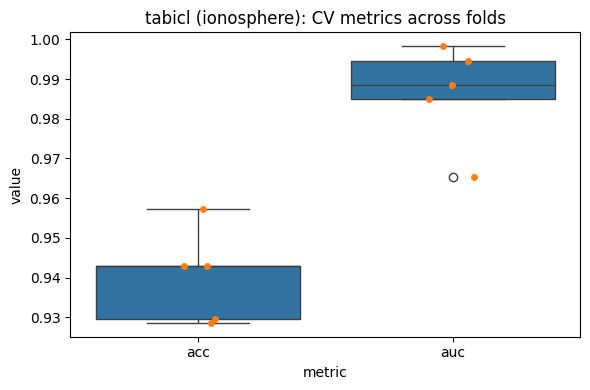

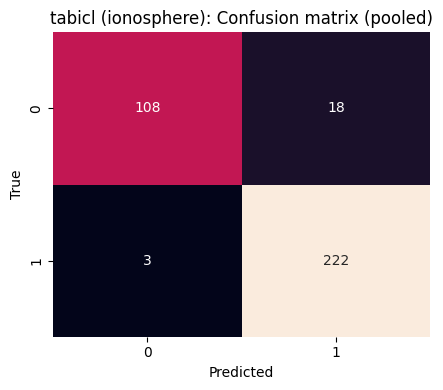

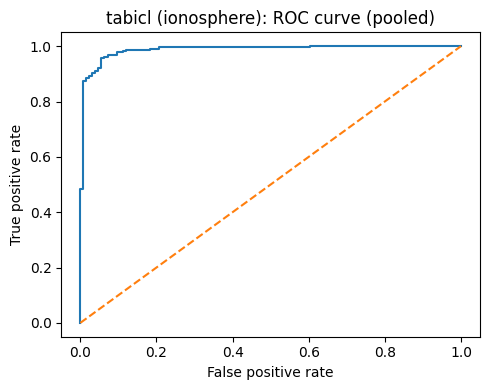

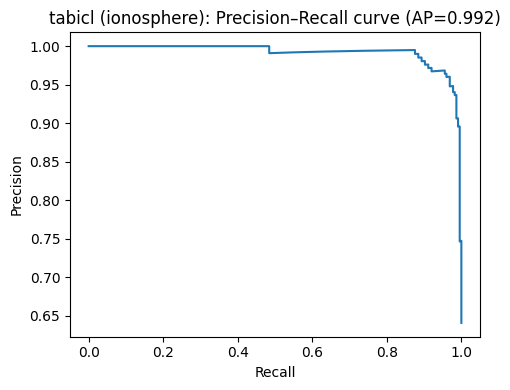

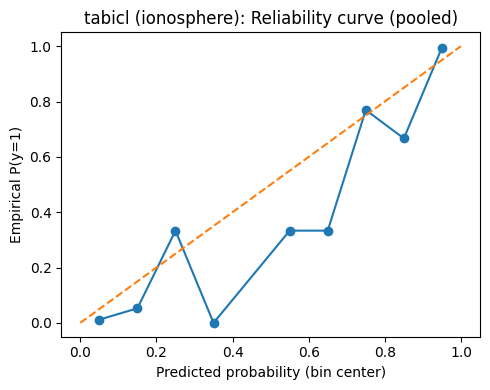

In [8]:
plot_model_results("tabicl")

### Random Forest, XGBoost, CatBoost and LightGBM

In [9]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

y_bin = y.astype(int)

p = float(y_bin.mean())
print("Positive rate (g=1):", p)
print("Majority baseline accuracy:", max(p, 1 - p))
print(55 * "-")

skf = cv

def _get_pos_proba(model, X_te):
    proba = model.predict_proba(X_te)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

def run_cv(model_name, make_model):
    fold_summaries = []
    all_y_true, all_y_pred, all_y_proba = [], [], []

    warm_n = min(256, len(X))
    warm = make_model()
    warm.fit(X.iloc[:warm_n], y_bin.iloc[:warm_n])
    _ = _get_pos_proba(warm, X.iloc[:warm_n])

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()

        t0 = time.perf_counter()
        model.fit(X_tr, y_tr)
        fit_s = time.perf_counter() - t0

        t0 = time.perf_counter()
        proba = _get_pos_proba(model, X_te)
        pred_s = time.perf_counter() - t0

        y_hat = (proba >= 0.5).astype(int)

        bal_acc = balanced_accuracy_score(y_te, y_hat)
        acc = accuracy_score(y_te, y_hat)
        auc = roc_auc_score(y_te, proba)

        fold_summaries.append({"fold": fold, "bal_acc": bal_acc, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
        all_y_true.append(y_te.to_numpy())
        all_y_pred.append(y_hat)
        all_y_proba.append(proba)

        print(
            f"{model_name} Fold {fold}: "
            f"BAL_ACC={bal_acc:.4f} ACC={acc:.4f} AUC={auc:.4f} | "
            f"fit={fit_s:.3f}s pred={pred_s:.3f}s"
        )

    cv_metrics_df = pd.DataFrame(fold_summaries)
    y_true_cv = np.concatenate(all_y_true)
    y_pred_cv = np.concatenate(all_y_pred)
    y_proba_cv = np.concatenate(all_y_proba)

    MODEL_RESULTS[model_name] = {
        "cv_metrics_df": cv_metrics_df,
        "y_true_cv": y_true_cv,
        "y_pred_cv": y_pred_cv,
        "y_proba_cv": y_proba_cv,
        "dataset": dataset_label,
    }

    print(
        f"\n{model_name} 5-fold CV: "
        f"BAL_ACC={cv_metrics_df['bal_acc'].mean():.4f}±{cv_metrics_df['bal_acc'].std():.4f}, "
        f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
        f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
    )
    print(
        f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
        f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
    )
    print(55 * "-")

models_to_run = {}

models_to_run["rf"] = lambda: RandomForestClassifier(
    n_estimators=500,
    random_state=20,
    n_jobs=-1,
)

models_to_run["xgb"] = lambda: XGBClassifier(
    random_state=20,
    n_jobs=-1,
    eval_metric="logloss",
)

models_to_run["cat"] = lambda: CatBoostClassifier(
    random_seed=20,
    verbose=False,
)

models_to_run["lgbm"] = lambda: LGBMClassifier(
    random_state=20,
    n_jobs=-1,
    verbose=-1,
)

for name, factory in models_to_run.items():
    run_cv(name, factory)


Positive rate (g=1): 0.6410256410256411
Majority baseline accuracy: 0.6410256410256411
-------------------------------------------------------
rf Fold 1: BAL_ACC=0.9312 ACC=0.9437 AUC=0.9919 | fit=0.531s pred=0.067s
rf Fold 2: BAL_ACC=0.9178 ACC=0.9286 AUC=0.9671 | fit=0.543s pred=0.066s
rf Fold 3: BAL_ACC=0.9089 ACC=0.9286 AUC=0.9884 | fit=0.534s pred=0.066s
rf Fold 4: BAL_ACC=0.9400 ACC=0.9571 AUC=0.9867 | fit=0.540s pred=0.066s
rf Fold 5: BAL_ACC=0.8956 ACC=0.9000 AUC=0.9653 | fit=0.532s pred=0.065s

rf 5-fold CV: BAL_ACC=0.9187±0.0176, ACC=0.9316±0.0213, AUC=0.9799±0.0126
Timing: fit=0.54s±0.01, predict=0.07s±0.00
-------------------------------------------------------
xgb Fold 1: BAL_ACC=0.9231 ACC=0.9437 AUC=0.9966 | fit=0.044s pred=0.003s
xgb Fold 2: BAL_ACC=0.9178 ACC=0.9286 AUC=0.9644 | fit=0.042s pred=0.003s
xgb Fold 3: BAL_ACC=0.8489 ACC=0.8857 AUC=0.9547 | fit=0.042s pred=0.003s
xgb Fold 4: BAL_ACC=0.9689 ACC=0.9714 AUC=0.9778 | fit=0.046s pred=0.003s
xgb Fold 5: BAL_ACC=0.

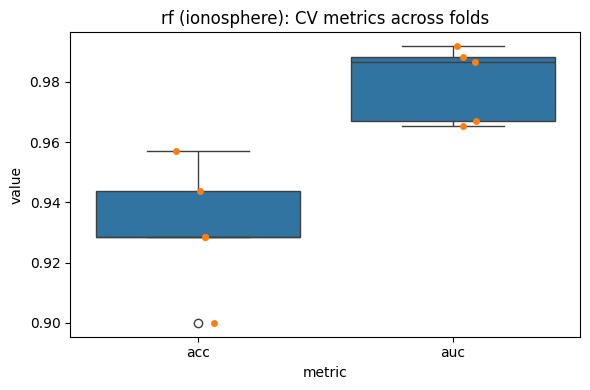

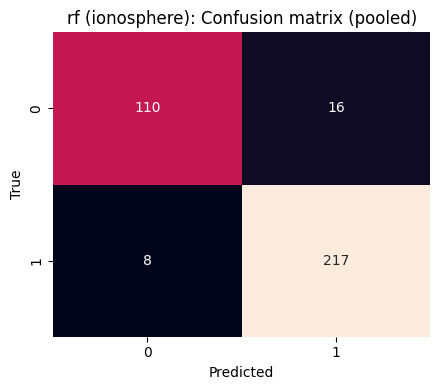

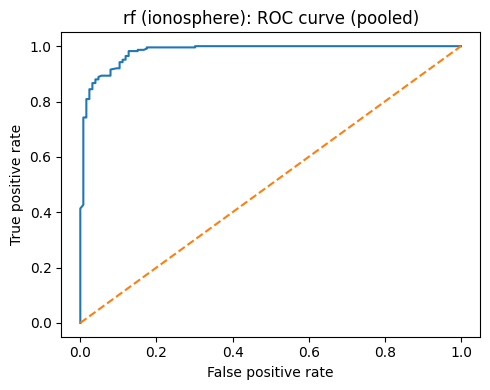

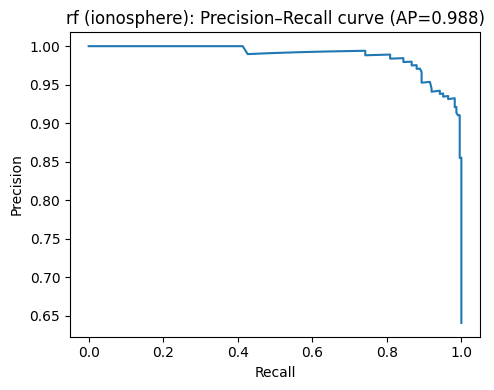

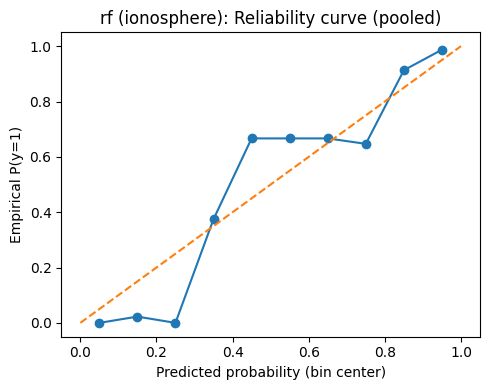

In [10]:
plot_model_results("rf")

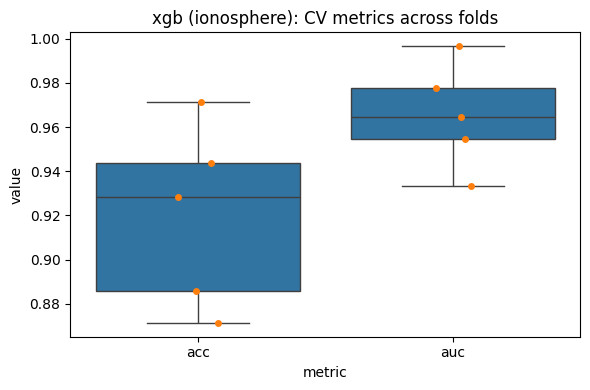

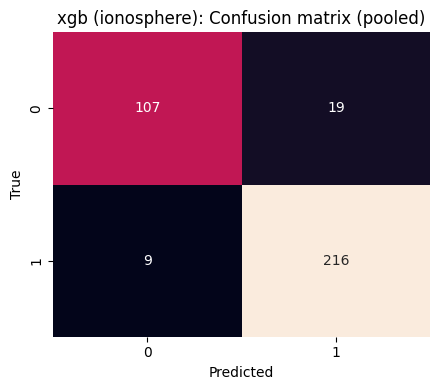

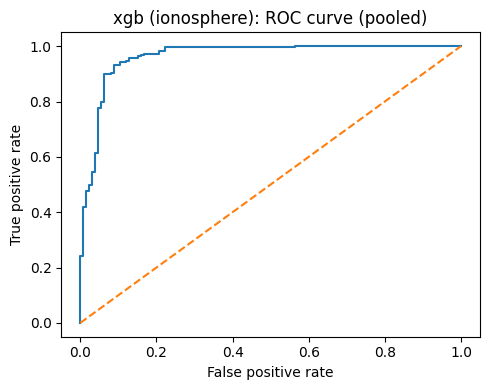

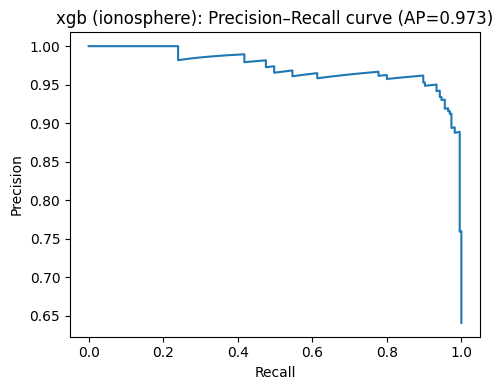

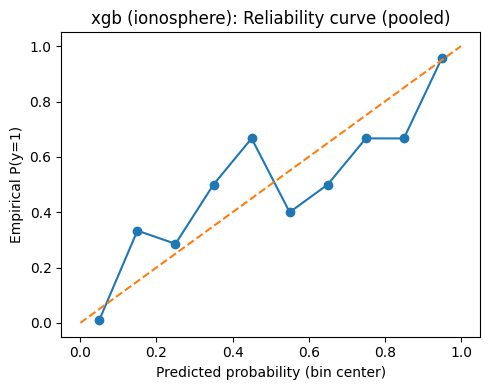

In [11]:
plot_model_results("xgb")

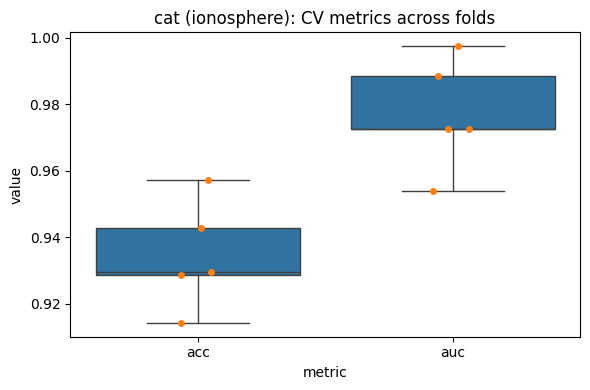

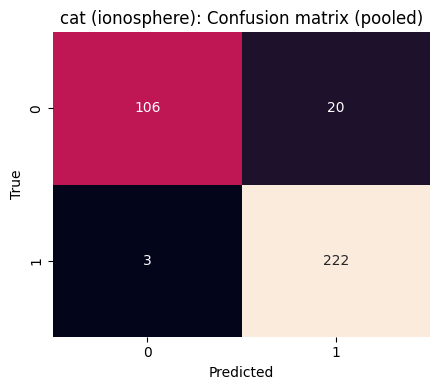

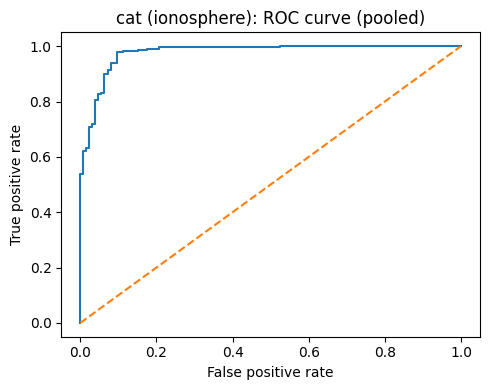

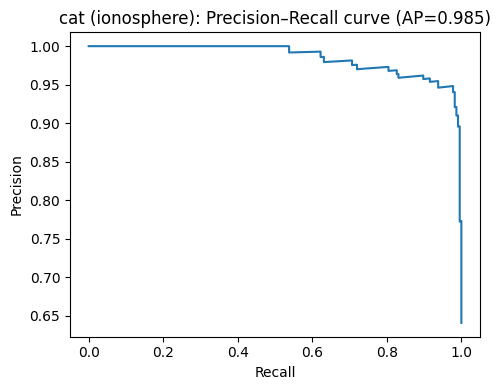

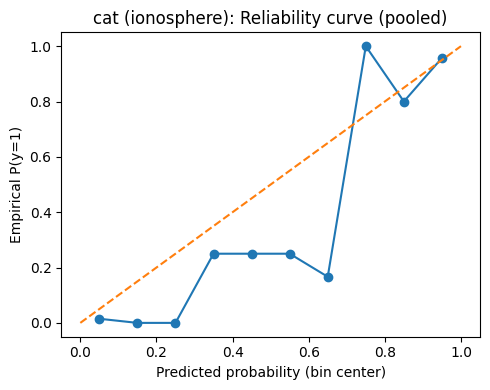

In [12]:
plot_model_results("cat")

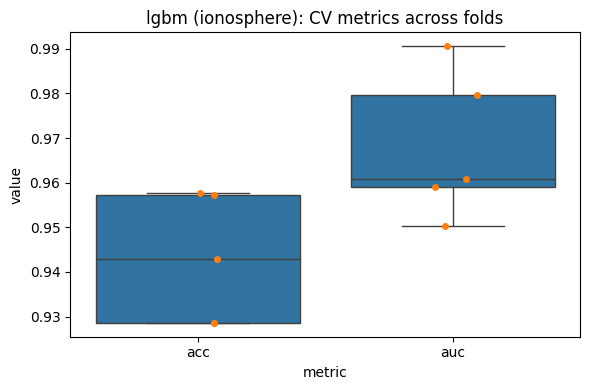

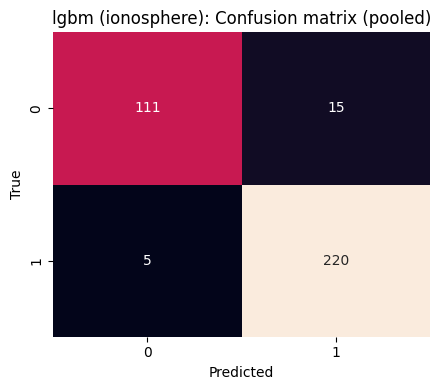

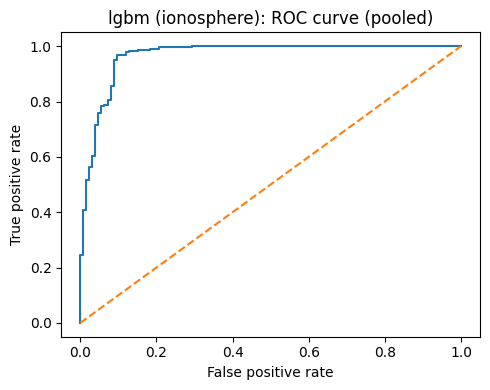

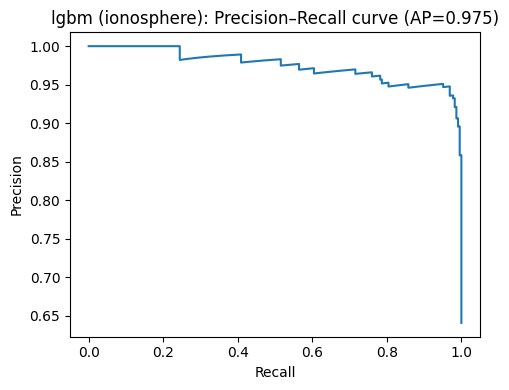

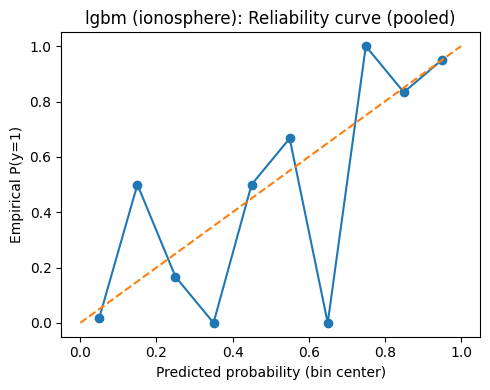

In [13]:
plot_model_results("lgbm")

In [14]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv_df = res.get("cv_metrics_df", None)
    if cv_df is None or cv_df.empty:
        continue
    rows.append({
        "model": name,
        "acc_mean": cv_df["acc"].mean(),
        "acc_std": cv_df["acc"].std(ddof=1),
        "auc_mean": cv_df["auc"].mean(),
        "auc_std": cv_df["auc"].std(ddof=1),
        "fit_s_mean": cv_df["fit_s"].mean() if "fit_s" in cv_df.columns else None,
        "pred_s_mean": cv_df["pred_s"].mean() if "pred_s" in cv_df.columns else None,
        "n_folds": int(cv_df.shape[0]),
    })

summary_df = pd.DataFrame(rows).sort_values("auc_mean", ascending=False).reset_index(drop=True)

for c in ["acc_mean", "acc_std", "auc_mean", "auc_std", "fit_s_mean", "pred_s_mean"]:
    if c in summary_df.columns:
        summary_df[c] = summary_df[c].astype(float)

display(summary_df.style.format({
    "acc_mean": "{:.4f}",
    "acc_std": "{:.4f}",
    "auc_mean": "{:.4f}",
    "auc_std": "{:.4f}",
    "fit_s_mean": "{:.3f}",
    "pred_s_mean": "{:.3f}",
}))

,model,acc_mean,acc_std,auc_mean,auc_std,fit_s_mean,pred_s_mean,n_folds
0,tabpfn,0.9544,0.0187,0.9863,0.0108,0.204,0.668,5
1,tabicl,0.9402,0.0117,0.9863,0.0128,0.382,0.391,5
2,rf,0.9316,0.0213,0.9799,0.0126,0.536,0.066,5
3,cat,0.9345,0.0162,0.9769,0.0168,2.178,0.002,5
4,lgbm,0.9430,0.0144,0.9681,0.0165,0.023,0.002,5
5,xgb,0.9202,0.0413,0.9654,0.0238,0.043,0.003,5


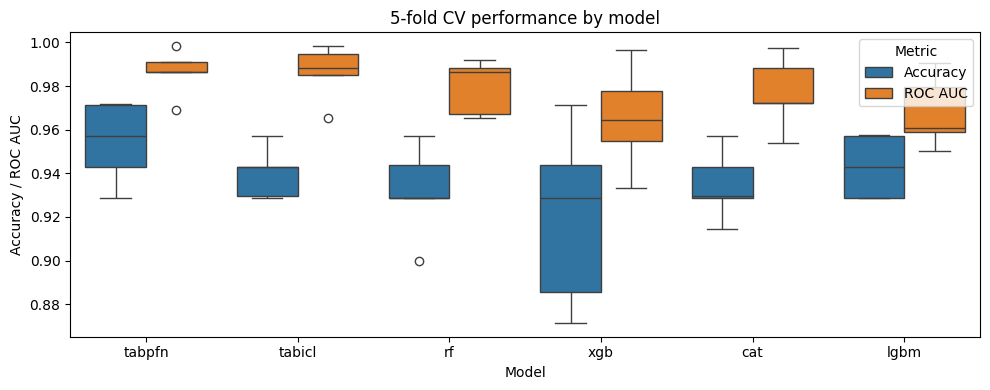

In [15]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv_df = res.get("cv_metrics_df")
    if cv_df is None or cv_df.empty:
        continue
    tmp = cv_df.copy()
    tmp["model"] = name
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

m_long = cv_all.melt(
    id_vars=["model", "fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}
m_long["metric"] = m_long["metric"].map(metric_names)

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=m_long, x="model", y="value", hue="metric")

ax.set_xlabel("Model")
ax.set_ylabel("Accuracy / ROC AUC")
ax.set_title("5-fold CV performance by model")

ax.legend(title="Metric", loc="upper right", frameon=True)

plt.tight_layout()
plt.show()


### Optuna optimization

In [16]:
def _cv_auc_for_model(make_model, X, y_bin, skf, trial=None):
    aucs = []
    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()
        model.fit(X_tr, y_tr)
        proba = _get_pos_proba(model, X_te)
        auc = roc_auc_score(y_te, proba)
        aucs.append(auc)

        if trial is not None:
            trial.report(float(np.mean(aucs)), step=fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

    return float(np.mean(aucs))

def _cv_auc_acc_for_model(make_model, X, y_bin, skf, trial=None):
    aucs, accs = [], []
    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()
        model.fit(X_tr, y_tr)

        proba = _get_pos_proba(model, X_te)
        y_hat = (proba >= 0.5).astype(int)

        aucs.append(roc_auc_score(y_te, proba))
        accs.append(accuracy_score(y_te, y_hat))

        if trial is not None:
            trial.report(float(np.mean(aucs)), step=fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

    return float(np.mean(aucs)), float(np.mean(accs))


def optuna_optimize(model_key, objective_fn, n_trials=40, seed=20, timeout=None):
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=seed),
        pruner=MedianPruner(n_warmup_steps=2),
    )
    study.optimize(objective_fn, n_trials=n_trials, timeout=timeout, show_progress_bar=True)

    MODEL_RESULTS[f"{model_key}_optuna"] = {
        "best_value": study.best_value,
        "best_params": study.best_params,
        "study": study,
    }

    print(f"{model_key} Optuna best mean AUC = {study.best_value:.4f}")
    print("Best params:", study.best_params)
    return study.best_params


In [17]:
def rf_objective(trial):
    max_depth_raw = trial.suggest_int("max_depth", 0, 30)

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200, log=True),
        "max_depth": None if max_depth_raw == 0 else max_depth_raw,
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced_subsample"]),
        "bootstrap": True,
        "max_samples": trial.suggest_float("max_samples", 0.7, 1.0),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.002),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]),
    }

    def make_model():
        return RandomForestClassifier(random_state=20, n_jobs=-1, **params)

    return _cv_auc_for_model(make_model, X, y_bin, skf, trial=trial)

best_rf = optuna_optimize("rf", rf_objective, n_trials=100, seed=20)

best_rf["max_depth"] = None if best_rf["max_depth"] == 0 else best_rf["max_depth"]

run_cv("rf_opt", lambda: RandomForestClassifier(random_state=20, n_jobs=-1, **best_rf))

[I 2026-02-18 21:34:28,280] A new study created in memory with name: no-name-afa3bd4a-ac7a-42f2-9956-931705705bd7


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-18 21:34:37,077] Trial 0 finished with value: 0.9717606837606839 and parameters: {'max_depth': 18, 'n_estimators': 1042, 'min_samples_split': 11, 'min_samples_leaf': 5, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_samples': 0.897385439667644, 'ccp_alpha': 0.00038770043576589667, 'max_features': 0.3}. Best is trial 0 with value: 0.9717606837606839.
[I 2026-02-18 21:34:39,761] Trial 1 finished with value: 0.9645264957264958 and parameters: {'max_depth': 7, 'n_estimators': 427, 'min_samples_split': 11, 'min_samples_leaf': 5, 'criterion': 'gini', 'class_weight': None, 'max_samples': 0.8893759196690636, 'ccp_alpha': 0.001678995845827412, 'max_features': 0.7}. Best is trial 0 with value: 0.9717606837606839.
[I 2026-02-18 21:34:44,889] Trial 2 finished with value: 0.9751521367521366 and parameters: {'max_depth': 10, 'n_estimators': 609, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_samples': 0.77

In [18]:
def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 4000, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 50.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e3, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
    }

    def make_model():
        return XGBClassifier(
            random_state=20,
            n_jobs=-1,
            eval_metric="auc",
            tree_method="hist",
            **params,
        )

    return _cv_auc_for_model(make_model, X, y_bin, skf, trial=trial)

best_xgb = optuna_optimize("xgb", xgb_objective, n_trials=150, seed=20)

run_cv("xgb_opt", lambda: XGBClassifier(
    random_state=20,
    n_jobs=-1,
    eval_metric="auc",
    tree_method="hist",
    **best_xgb
))

[I 2026-02-18 21:41:35,871] A new study created in memory with name: no-name-62b99537-7e44-4d9c-a7f8-925f295124b6


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2026-02-18 21:41:37,058] Trial 0 finished with value: 0.9603418803418803 and parameters: {'n_estimators': 1164, 'max_depth': 10, 'learning_rate': 0.20744309804086816, 'subsample': 0.907918738653842, 'colsample_bytree': 0.5179447928084266, 'min_child_weight': 3.620683352673056, 'gamma': 3.786809420054081, 'reg_lambda': 1.2914145426220358, 'reg_alpha': 0.008347629978080211, 'max_delta_step': 2}. Best is trial 0 with value: 0.9603418803418803.
[I 2026-02-18 21:41:37,623] Trial 1 finished with value: 0.9572854700854702 and parameters: {'n_estimators': 451, 'max_depth': 8, 'learning_rate': 0.14341390920579675, 'subsample': 0.9251638198874976, 'colsample_bytree': 0.8876224469971814, 'min_child_weight': 0.013665331443561484, 'gamma': 1.1669373513289516, 'reg_lambda': 32.187273991788985, 'reg_alpha': 1.422210713315449e-06, 'max_delta_step': 2}. Best is trial 0 with value: 0.9603418803418803.
[I 2026-02-18 21:41:40,207] Trial 2 finished with value: 0.9334871794871795 and parameters: {'n_esti

In [19]:
def cat_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 3000),
        "depth": trial.suggest_int("depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 100.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 2.0),
        "rsm": trial.suggest_float("rsm", 0.3, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 254),
    }

    def make_model():
        return CatBoostClassifier(
            random_seed=20,
            verbose=False,
            loss_function="Logloss",
            **params,
        )

    return _cv_auc_for_model(make_model, X, y_bin, skf, trial=trial)

best_cat = optuna_optimize("cat", cat_objective, n_trials=100, seed=20)

run_cv("cat_opt", lambda: CatBoostClassifier(
    random_seed=20,
    verbose=False,
    loss_function="Logloss",
    **best_cat
))

[I 2026-02-18 21:47:00,378] A new study created in memory with name: no-name-d6c1f4fc-1024-4498-be13-4dccb250036a


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-02-18 21:50:49,800] Trial 0 finished with value: 0.9812376068376067 and parameters: {'iterations': 1847, 'depth': 10, 'learning_rate': 0.20744309804086816, 'l2_leaf_reg': 42.822789554694225, 'random_strength': 0.0013917407466453636, 'bagging_temperature': 1.3835151635177678, 'rsm': 0.5650766594037857, 'border_count': 147}. Best is trial 0 with value: 0.9812376068376067.
[I 2026-02-18 21:51:01,464] Trial 1 finished with value: 0.9710495726495727 and parameters: {'iterations': 2042, 'depth': 3, 'learning_rate': 0.025249009486299902, 'l2_leaf_reg': 27.366034315250744, 'random_strength': 1.355234465485695, 'bagging_temperature': 1.7006552795499907, 'rsm': 0.8426714257960539, 'border_count': 40}. Best is trial 0 with value: 0.9812376068376067.
[I 2026-02-18 21:51:12,235] Trial 2 finished with value: 0.9763692307692308 and parameters: {'iterations': 526, 'depth': 8, 'learning_rate': 0.022560790447398543, 'l2_leaf_reg': 3.233047072413852, 'random_strength': 2.6946485152240367, 'baggin

In [20]:
scale_pos_weight = float((y_bin == 1).sum() / max(1, (y_bin == 0).sum()))

def lgbm_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 5000, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 80),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 0, 5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e3, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 2.0),
    }

    use_spw = trial.suggest_categorical("use_scale_pos_weight", [False, True])
    if use_spw:
        params["scale_pos_weight"] = scale_pos_weight

    def make_model():
        return LGBMClassifier(
            random_state=20,
            n_jobs=-1,
            verbose=-1,
            objective="binary",
            **params,
        )

    return _cv_auc_for_model(make_model, X, y_bin, skf, trial=trial)

best_lgbm = optuna_optimize("lgbm", lgbm_objective, n_trials=150, seed=20)

run_cv("lgbm_opt", lambda: LGBMClassifier(
    random_state=20,
    n_jobs=-1,
    verbose=-1,
    objective="binary",
    **{k: v for k, v in best_lgbm.items() if k != "use_scale_pos_weight"}
))


[I 2026-02-18 23:25:40,383] A new study created in memory with name: no-name-23c2c65a-640f-42d0-bf4b-e554b6647c2e


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2026-02-18 23:25:40,714] Trial 0 finished with value: 0.9657641025641027 and parameters: {'n_estimators': 1327, 'learning_rate': 0.21185173649266384, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.845878790879442, 'subsample_freq': 2, 'colsample_bytree': 0.7592554727240404, 'reg_lambda': 8.865613484080416, 'reg_alpha': 5.554589398756315e-07, 'min_split_gain': 0.5446328041331678, 'use_scale_pos_weight': True}. Best is trial 0 with value: 0.9657641025641027.
[I 2026-02-18 23:25:41,323] Trial 1 finished with value: 0.932594871794872 and parameters: {'n_estimators': 3088, 'learning_rate': 0.13967886922560296, 'num_leaves': 12, 'max_depth': 0, 'min_child_samples': 62, 'subsample': 0.6196091080998047, 'subsample_freq': 1, 'colsample_bytree': 0.9288127655848812, 'reg_lambda': 499.65950879234515, 'reg_alpha': 0.0011354858383034237, 'min_split_gain': 0.3575610396999531, 'use_scale_pos_weight': False}. Best is trial 0 with value: 0.9657641025641027.
[I 2026-02-18 2


=== rf_opt using rf_optuna best params ===
{'max_depth': 30, 'n_estimators': 595, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': None, 'max_samples': 0.9339527438480968, 'ccp_alpha': 0.0006508997301224579, 'max_features': 'log2'}
rf_opt Fold 1: BAL_ACC=0.9312 ACC=0.9437 AUC=0.9923 | fit=0.677s pred=0.076s
rf_opt Fold 2: BAL_ACC=0.9178 ACC=0.9286 AUC=0.9689 | fit=0.665s pred=0.076s
rf_opt Fold 3: BAL_ACC=0.9089 ACC=0.9286 AUC=0.9884 | fit=0.670s pred=0.068s
rf_opt Fold 4: BAL_ACC=0.9400 ACC=0.9571 AUC=0.9893 | fit=0.690s pred=0.067s
rf_opt Fold 5: BAL_ACC=0.8956 ACC=0.9000 AUC=0.9653 | fit=0.868s pred=0.077s

rf_opt 5-fold CV: BAL_ACC=0.9187±0.0176, ACC=0.9316±0.0213, AUC=0.9809±0.0127
Timing: fit=0.71s±0.09, predict=0.07s±0.00
-------------------------------------------------------


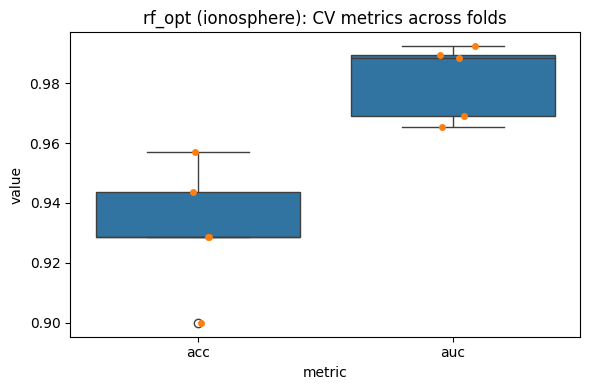

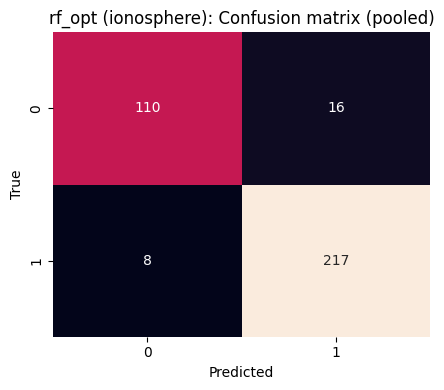

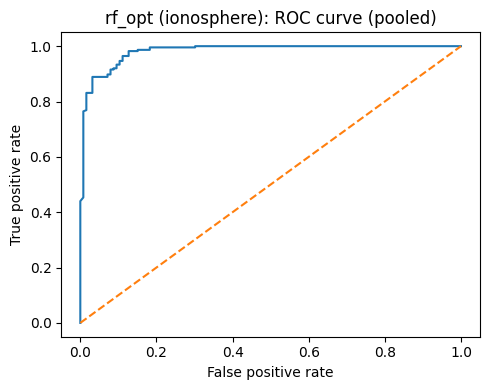

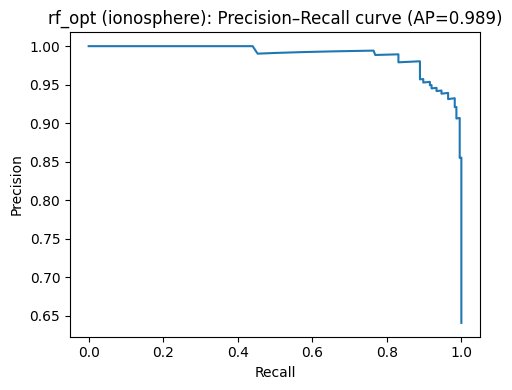

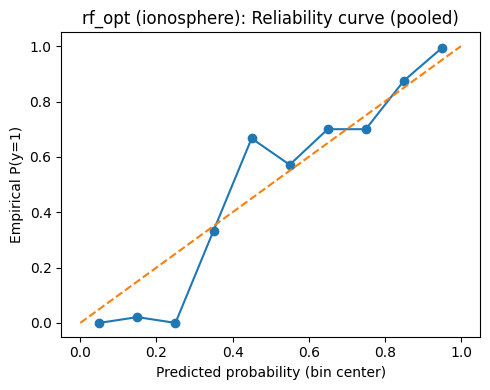


=== xgb_opt using xgb_optuna best params ===
{'n_estimators': 3361, 'max_depth': 8, 'learning_rate': 0.04606148718557765, 'subsample': 0.8081746381578859, 'colsample_bytree': 0.5501399326392424, 'min_child_weight': 0.3630013896899041, 'gamma': 1.18321618702663, 'reg_lambda': 0.007366783978301627, 'reg_alpha': 2.579721861145984e-06, 'max_delta_step': 9}
xgb_opt Fold 1: BAL_ACC=0.9120 ACC=0.9296 AUC=0.9923 | fit=0.675s pred=0.005s
xgb_opt Fold 2: BAL_ACC=0.9400 ACC=0.9571 AUC=0.9707 | fit=0.700s pred=0.006s
xgb_opt Fold 3: BAL_ACC=0.9089 ACC=0.9286 AUC=0.9716 | fit=0.683s pred=0.005s
xgb_opt Fold 4: BAL_ACC=0.9600 ACC=0.9714 AUC=0.9884 | fit=0.667s pred=0.005s
xgb_opt Fold 5: BAL_ACC=0.8867 ACC=0.9000 AUC=0.9476 | fit=0.660s pred=0.006s

xgb_opt 5-fold CV: BAL_ACC=0.9215±0.0287, ACC=0.9373±0.0278, AUC=0.9741±0.0177
Timing: fit=0.68s±0.02, predict=0.01s±0.00
-------------------------------------------------------


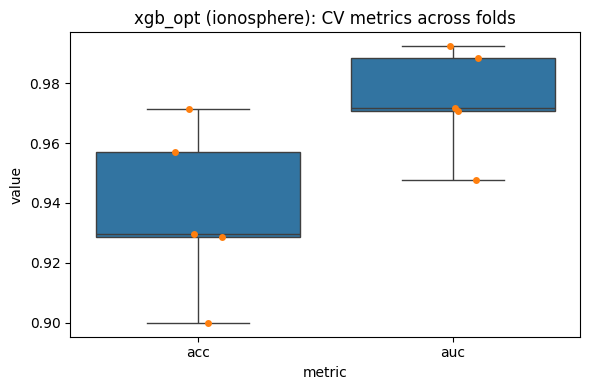

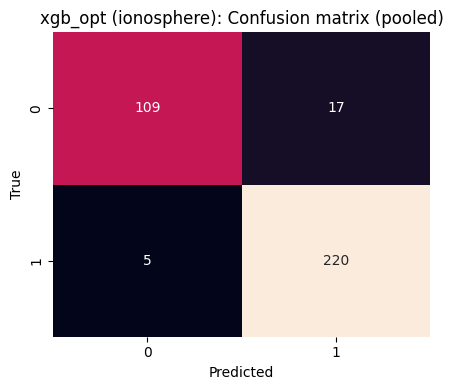

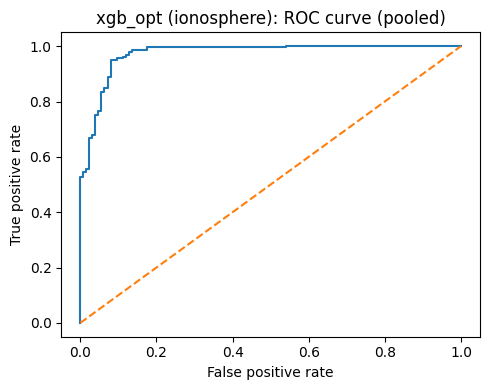

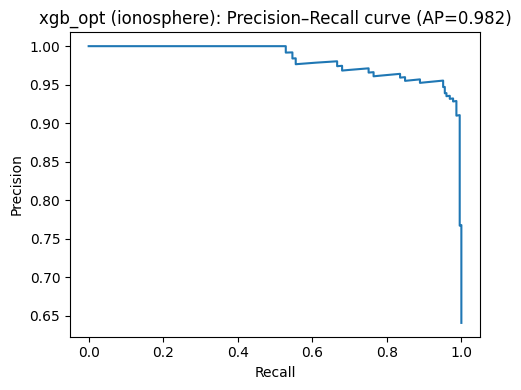

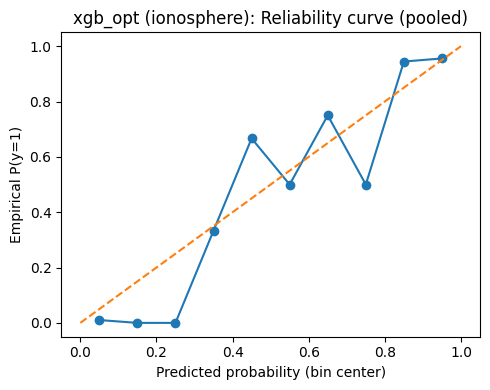


=== lgbm_opt using lgbm_optuna best params ===
{'n_estimators': 2577, 'learning_rate': 0.02699493142163229, 'num_leaves': 71, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.9661299769496826, 'subsample_freq': 4, 'colsample_bytree': 0.5112515770525586, 'reg_lambda': 0.01212359940991412, 'reg_alpha': 0.0009496796655430826, 'min_split_gain': 0.033094986291305556}
lgbm_opt Fold 1: BAL_ACC=0.9312 ACC=0.9437 AUC=0.9966 | fit=0.119s pred=0.002s
lgbm_opt Fold 2: BAL_ACC=0.9400 ACC=0.9571 AUC=0.9644 | fit=0.116s pred=0.002s
lgbm_opt Fold 3: BAL_ACC=0.9089 ACC=0.9286 AUC=0.9769 | fit=0.114s pred=0.002s
lgbm_opt Fold 4: BAL_ACC=0.9600 ACC=0.9714 AUC=0.9929 | fit=0.115s pred=0.002s
lgbm_opt Fold 5: BAL_ACC=0.8867 ACC=0.9000 AUC=0.9618 | fit=0.113s pred=0.002s

lgbm_opt 5-fold CV: BAL_ACC=0.9254±0.0284, ACC=0.9402±0.0275, AUC=0.9785±0.0159
Timing: fit=0.12s±0.00, predict=0.00s±0.00
-------------------------------------------------------


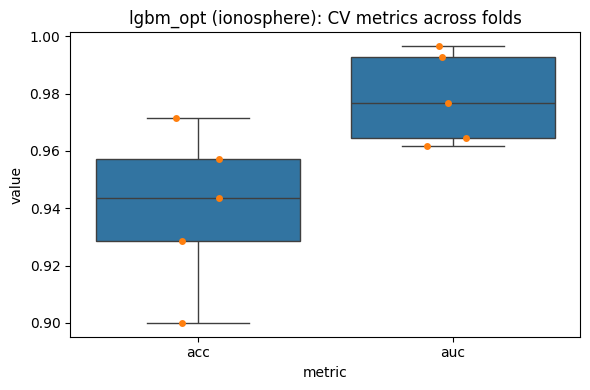

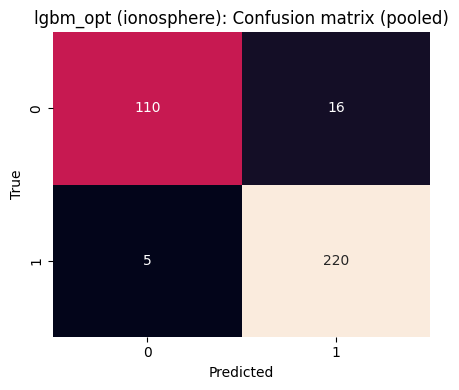

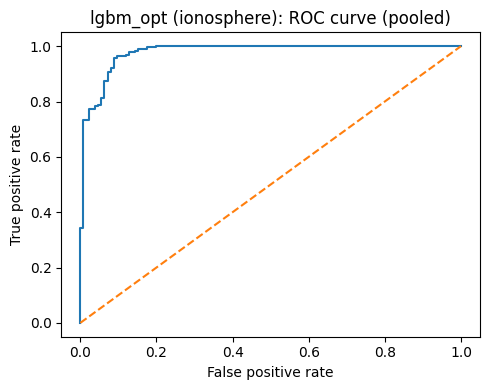

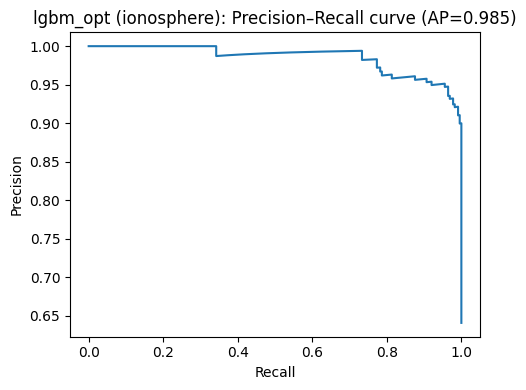

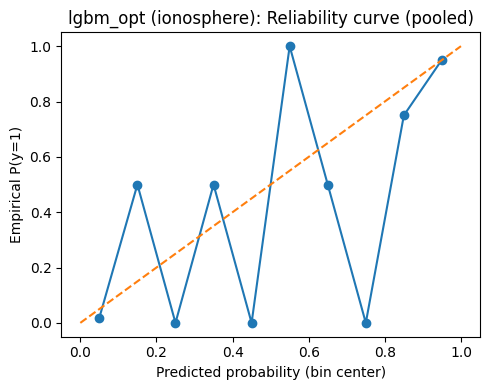


=== cat_opt using cat_optuna best params ===
{'iterations': 471, 'depth': 10, 'learning_rate': 0.2680006223110324, 'l2_leaf_reg': 54.4038308433765, 'random_strength': 0.853267316693739, 'bagging_temperature': 0.3802653307842705, 'rsm': 0.3171420227397942, 'border_count': 176}
cat_opt Fold 1: BAL_ACC=0.9038 ACC=0.9296 AUC=0.9974 | fit=10.235s pred=0.002s
cat_opt Fold 2: BAL_ACC=0.9289 ACC=0.9429 AUC=0.9787 | fit=10.191s pred=0.002s
cat_opt Fold 3: BAL_ACC=0.8889 ACC=0.9143 AUC=0.9760 | fit=10.131s pred=0.002s
cat_opt Fold 4: BAL_ACC=0.9200 ACC=0.9429 AUC=0.9938 | fit=10.207s pred=0.003s
cat_opt Fold 5: BAL_ACC=0.9089 ACC=0.9286 AUC=0.9742 | fit=10.123s pred=0.004s

cat_opt 5-fold CV: BAL_ACC=0.9101±0.0153, ACC=0.9316±0.0119, AUC=0.9840±0.0108
Timing: fit=10.18s±0.05, predict=0.00s±0.00
-------------------------------------------------------


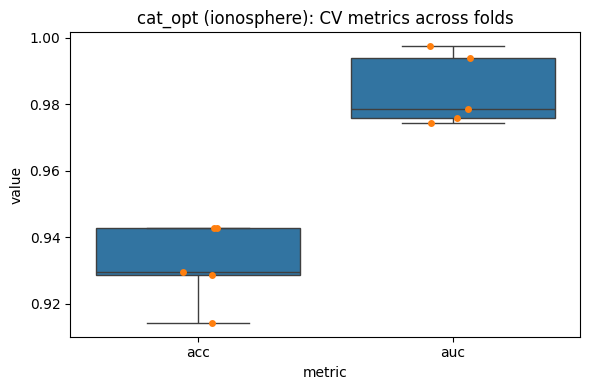

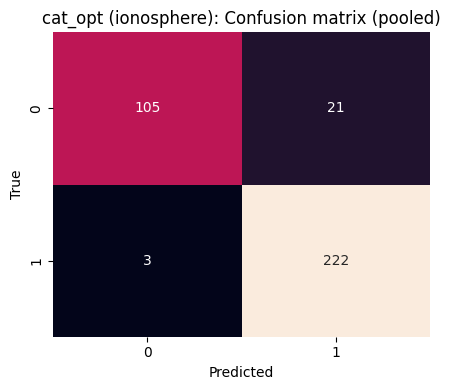

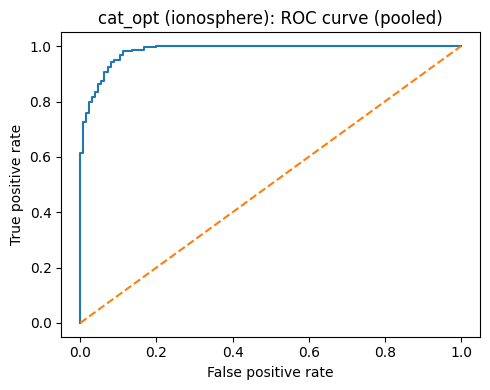

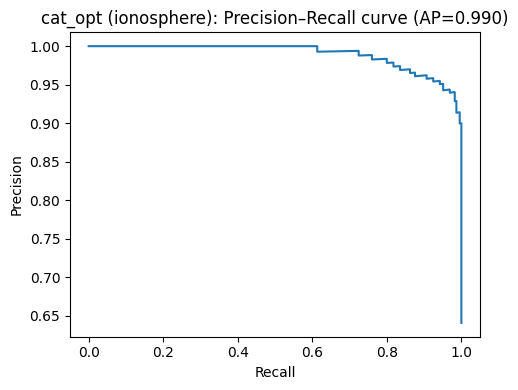

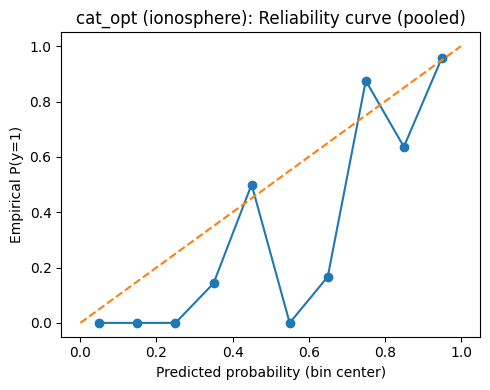

In [21]:
opt_models = {
    "rf_opt":  ("rf_optuna",  lambda p: RandomForestClassifier(random_state=20, n_jobs=-1, **p)),
    "xgb_opt": ("xgb_optuna", lambda p: XGBClassifier(
        random_state=20, n_jobs=-1, eval_metric="logloss", tree_method="hist", **p
    )),
    "lgbm_opt": ("lgbm_optuna", lambda p: LGBMClassifier(random_state=20, n_jobs=-1, verbose=-1, **p)),
    "cat_opt": ("cat_optuna", lambda p: CatBoostClassifier(random_seed=20, verbose=False, loss_function="Logloss", **p)),
}

for run_key, (opt_key, builder) in opt_models.items():
    if opt_key not in MODEL_RESULTS:
        print(f"Skipping {run_key}: missing MODEL_RESULTS['{opt_key}'] (run Optuna first).")
        continue

    best_params = dict(MODEL_RESULTS[opt_key]["best_params"])
    best_params.pop("use_scale_pos_weight", None)

    print(f"\n=== {run_key} using {opt_key} best params ===")
    print(best_params)

    run_cv(run_key, lambda bp=best_params: builder(bp))

    MODEL_RESULTS[run_key]["dataset"] = dataset_label
    plot_model_results(run_key)

In [22]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv_df = res.get("cv_metrics_df", None)
    if cv_df is None or getattr(cv_df, "empty", True):
        continue
    if not {"acc", "auc"}.issubset(set(cv_df.columns)):
        continue

    rows.append({
        "model": name,
        "dataset": res.get("dataset", "unknown"),
        "acc_mean": cv_df["acc"].mean(),
        "acc_std": cv_df["acc"].std(ddof=1),
        "auc_mean": cv_df["auc"].mean(),
        "auc_std": cv_df["auc"].std(ddof=1),
        "fit_s_mean": cv_df["fit_s"].mean() if "fit_s" in cv_df.columns else np.nan,
        "pred_s_mean": cv_df["pred_s"].mean() if "pred_s" in cv_df.columns else np.nan,
        "n_folds": int(cv_df.shape[0]),
    })

summary_df = pd.DataFrame(rows)

for c in ["acc_mean", "acc_std", "auc_mean", "auc_std", "fit_s_mean", "pred_s_mean"]:
    if c in summary_df.columns:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce")

summary_df = summary_df.sort_values("auc_mean", ascending=False).reset_index(drop=True)

display(summary_df.style.format({
    "acc_mean": "{:.4f}",
    "acc_std": "{:.4f}",
    "auc_mean": "{:.4f}",
    "auc_std": "{:.4f}",
    "fit_s_mean": "{:.3f}",
    "pred_s_mean": "{:.3f}",
}))


,model,dataset,acc_mean,acc_std,auc_mean,auc_std,fit_s_mean,pred_s_mean,n_folds
0,tabpfn,ionosphere,0.9544,0.0187,0.9863,0.0108,0.204,0.668,5
1,tabicl,ionosphere,0.9402,0.0117,0.9863,0.0128,0.382,0.391,5
2,cat_opt,ionosphere,0.9316,0.0119,0.9840,0.0108,10.177,0.003,5
3,rf_opt,ionosphere,0.9316,0.0213,0.9809,0.0127,0.714,0.073,5
4,rf,ionosphere,0.9316,0.0213,0.9799,0.0126,0.536,0.066,5
5,lgbm_opt,ionosphere,0.9402,0.0275,0.9785,0.0159,0.115,0.002,5
6,cat,ionosphere,0.9345,0.0162,0.9769,0.0168,2.178,0.002,5
7,xgb_opt,ionosphere,0.9373,0.0278,0.9741,0.0177,0.677,0.005,5
8,lgbm,ionosphere,0.9430,0.0144,0.9681,0.0165,0.023,0.002,5
9,xgb,ionosphere,0.9202,0.0413,0.9654,0.0238,0.043,0.003,5


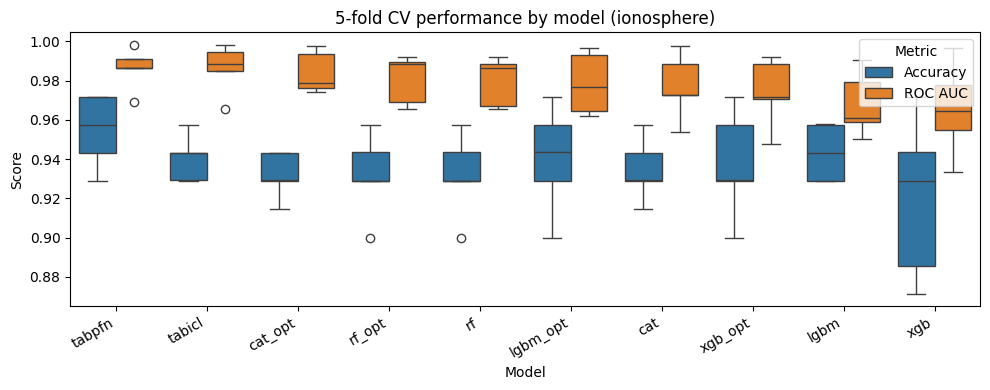

In [23]:
model_order = summary_df["model"].tolist()

rows = []
for name, res in MODEL_RESULTS.items():
    cv_df = res.get("cv_metrics_df")
    if cv_df is None or getattr(cv_df, "empty", True):
        continue
    if not {"fold", "acc", "auc"}.issubset(set(cv_df.columns)):
        continue

    tmp = cv_df.copy()
    tmp["model"] = name
    tmp["dataset"] = res.get("dataset", "unknown")
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

m_long = cv_all.melt(
    id_vars=["dataset", "model", "fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}
m_long["metric"] = m_long["metric"].map(metric_names)

m_long["model"] = pd.Categorical(m_long["model"], categories=model_order, ordered=True)
m_long = m_long.sort_values("model")

plt.figure(figsize=(max(10, 0.7 * len(model_order)), 4))
ax = sns.boxplot(data=m_long, x="model", y="value", hue="metric", order=model_order)

ax.set_xlabel("Model")
ax.set_ylabel("Score")
datasets = ", ".join(sorted(m_long["dataset"].unique()))
ax.set_title(f"5-fold CV performance by model ({datasets})")

ax.legend(title="Metric", loc="upper right", frameon=True)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


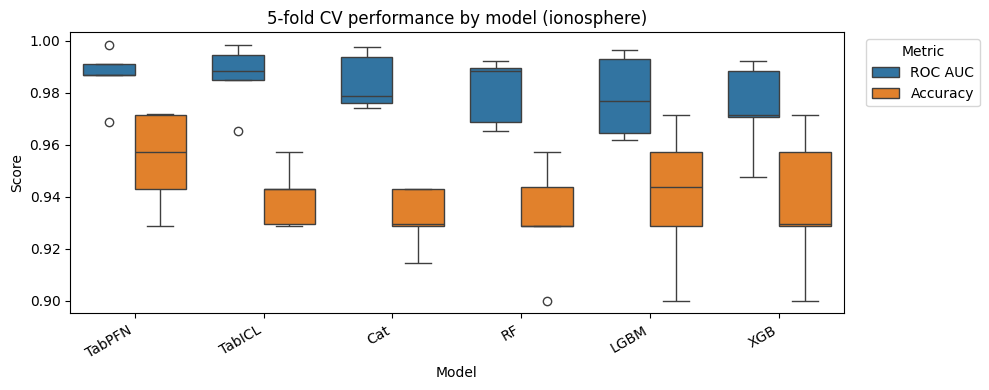

In [24]:
names = {
    "tabicl": "TabICL",
    "tabpfn": "TabPFN",
    "rf_opt": "RF",
    "xgb_opt": "XGB",
    "lgbm_opt": "LGBM",
    "cat_opt": "Cat",
}

wanted_keys = ["tabicl", "tabpfn", "cat_opt", "xgb_opt", "lgbm_opt", "rf_opt"]
present_keys = [k for k in wanted_keys if k in MODEL_RESULTS]

rows = []
for key in present_keys:
    res = MODEL_RESULTS[key]
    cv_df = res.get("cv_metrics_df")
    if cv_df is None or getattr(cv_df, "empty", True):
        continue
    if not {"fold", "acc", "auc"}.issubset(set(cv_df.columns)):
        continue

    tmp = cv_df.copy()
    tmp["model"] = names[key]
    tmp["dataset"] = res.get("dataset", "unknown")
    tmp["_key"] = key
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

auc_rank = (
    cv_all.groupby("_key")["auc"]
    .mean()
    .sort_values(ascending=False)
)

present_keys_ranked = [k for k in auc_rank.index.tolist() if k in present_keys]
model_order = [names[k] for k in present_keys_ranked]

m_long = cv_all.melt(
    id_vars=["dataset", "model", "fold", "_key"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_order = ["auc", "acc"]
metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}

m_long["metric"] = pd.Categorical(m_long["metric"], categories=metric_order, ordered=True)
m_long["metric"] = m_long["metric"].map(metric_names)

m_long["model"] = pd.Categorical(m_long["model"], categories=model_order, ordered=True)
m_long = m_long.sort_values(["model", "metric"])

plt.figure(figsize=(max(10, 0.7 * len(model_order)), 4))
ax = sns.boxplot(
    data=m_long,
    x="model",
    y="value",
    hue="metric",
    order=model_order,
    hue_order=[metric_names[m] for m in metric_order],
)

ax.set_xlabel("Model")
ax.set_ylabel("Score")
datasets = ", ".join(sorted(m_long["dataset"].unique()))
ax.set_title(f"5-fold CV performance by model ({datasets})")

ax.legend(title="Metric", loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=True)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
